<a href="https://colab.research.google.com/github/Nahmadid/WeeklyReport/blob/main/pharma_UQ_noise_0.05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**First Approach**

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import optax
import sys
import jax.nn as jnn
# import jaxopt

#@title **Doxorubicin**

import numpy as np
from scipy.integrate import odeint

#Defining the model
def Pharma(
    t,
    f1 = 0.0 ,
    V1 = 254.5 ,
    V2 = 1000,
    k  = 20,
):
    def func(y, t):

        return [
            -k * (y[0]/V1 - y[0]/V2) + f1,
            k  * (y[0]/V1 - y[1]/V2),
        ]

    # defining initial conditions for 6 state variables
    y0 = [1, 0]
    return odeint(func, y0, t)



t_dense = jnp.linspace(0, 14, 15)[:, None]
y_dense = Pharma(np.ravel(t_dense))


# Data
t_data = np.array([0, 1, 2, 4, 7, 14])
Q1_measured = np.array([1, 0.582, 0.402, 0.389, 0.3884, 0.3880])
Q2_measured = np.array([0, 0.418, 0.598, 0.611, 0.6115, 0.612])

In [ ]:
# tmin,tmax=0.
tmin, tmax = t_dense[0,0], t_dense[-1,0]

#t = (t-np.min(t))/(np.max(t)-np.min(t))
def init_params(layers):
    keys = jax.random.split(jax.random.PRNGKey(seed), len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
        W = jax.random.normal(key, shape=(n_in, n_out)) / jnp.sqrt(n_in) # random initialization
        B = jax.random.normal(key, shape=(n_out,))
        # params.append({'W': W, 'B': B , 'k1': 0.0 , 'k2': 0.0, 'l0': 0.0})
        params.append({'W': W, 'B': B })
    return params


def fwd(params,t):
  t = 0.01 * t
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
    # X = jnp.sin(X@layer['W']+layer['B'])
  return X@last['W'] + last['B']

def fwd_extra(params,t):
  t = 0.01 * t
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
  X = X@last['W'] + last['B']
  return X



@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)




In [ ]:


def ODE_loss(t, y1, y2, ft):

    V1 = 254.5
    V2 = 1000
    f1 = 0.0
    k = jnn.softplus(ft(t))
    # k  = ft(t)

    y1_t = lambda t: jax.grad(lambda t: jnp.sum(y1(t)))(t)
    y2_t = lambda t: jax.grad(lambda t: jnp.sum(y2(t)))(t)

    ode1 = y1_t(t) + k * (y1(t)/V1 - y1(t)/V2)- f1
    ode2 = y2_t(t) - k * (y1(t)/V1 - y2(t)/V2)

    return ode1, ode2




#collocation points
N_c = 140

t_c = jnp.linspace(tmin, tmax, N_c+1)[:, None]

def loss_fun(params,params_extra, l1 ,l2 , t_i, t_d, t_c, data_IC, data):


    y1_func = lambda t: fwd(params, t)[:, [0]]
    y2_func = lambda t: fwd(params, t)[:, [1]]
    ft      = lambda t: fwd(params, t)[:, [2]]
    # ft     = lambda t: fwd_extra(params_extra, t)[:, [0]]



    # loss_y1, loss_y2, loss_y3 = ODE_loss(t_c, params, y1_func, y2_func, y3_func, f_t)
    loss_y1, loss_y2 = ODE_loss(t_c, y1_func, y2_func, ft)

    loss_y1 = l1*loss_y1
    loss_y2 = l2*loss_y2

    loss_ode1 = jnp.mean(loss_y1 ** 2)
    loss_ode2 = jnp.mean(loss_y2 ** 2)

    # Compute the loss for the initial conditions
    t_i = t_i.flatten()[:,None]
    pred_IC = jnp.concatenate([y1_func(t_i), y2_func(t_i)],axis=1)
    loss_IC = MSE(data_IC, pred_IC)

    # Compute the loss for Y_data
    t_d    = t_d.flatten()[:,None]
    pred_d = jnp.concatenate([y1_func(t_d), y2_func(t_d)],axis=1)
    loss_data = MSE(data, pred_d)

    #loss_data = MSE(data[:,0:3], pred_d[:,0:3])
    # loss_data = MSE(data[:, [0, 3]], pred_d[:, [0, 2]])


    return loss_IC, loss_data, loss_ode1, loss_ode2


# def loss_fun_total(params, params_extra,l1,l2, l3, t_i, t_d, t_c, data_IC, data, loss_weight):

#     loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3 = loss_fun(params, params_extra,l1,l2, l3, t_i, t_d, t_c, data_IC, data)

#     loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
#                 + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2\
#                 + loss_weight[4]*loss_ode3

#     return loss_total


def loss_fun_total(params, params_extra, l1,l2, t_i, t_d, t_c, data_IC, data, loss_weight):

    loss_IC, loss_data, loss_ode1, loss_ode2 = loss_fun(params, params_extra, l1,l2, t_i, t_d, t_c, data_IC, data)

    loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
                + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2

    return loss_total




@jax.jit
def update(opt_state, opt_state_extra, params, params_extra, params_l1, params_l2, opt_state_l1, opt_state_l2, t_i, t_data, t_c, IC, data, loss_weight):
  grads=jax.grad(loss_fun_total, argnums=[0,1,2,3])(params,params_extra, params_l1, params_l2, t_i, t_data, t_c, IC, data, loss_weight)

  #Update params
  updates, opt_state = optimizer.update(grads[0], opt_state)
  params = optax.apply_updates(params, updates)

  updates_extra, opt_state_extra = optimizer_ex.update(grads[1], opt_state_extra)
  params_extra = optax.apply_updates(params_extra, updates_extra)

  updates_l1, opt_state_l1 = optimizer.update(-grads[2], opt_state_l1)
  params_l1 = optax.apply_updates(params_l1, updates_l1)

  updates_l2, opt_state_l2 = optimizer.update(-grads[3], opt_state_l2)
  params_l2 = optax.apply_updates(params_l2, updates_l2)


  return opt_state, opt_state_extra, params, params_extra,  params_l1, params_l2, opt_state_l1, opt_state_l2





In [ ]:
import numpy as np
import random


# Define the number of seeds
num_seeds = 10

# Initialize arrays to store results
all_Q1 = []
all_Q2 = []
all_f = []

# Define your training hyperparameters
epochs_phase1 = 0  # 10000
epochs_phase2 = 50000
loss_weight_phase1 = [1, 1, 0, 0]
loss_weight_phase2 = [1, 1, 1, 1]

for sd in range(num_seeds):
    # Set the seed for reproducibility
    seed = random.randint(1, 1000)
    #initialization
    params = init_params([1] + [50]*6+[3])
    params_extra = init_params([1] + [20]*4+[1])  # Initialize parameters for the extra neural network

    optimizer = optax.adam(1e-3)
    opt_state = optimizer.init(params)
    optimizer_ex = optax.adam(1e-3)
    opt_state_extra = optimizer_ex.init(params_extra)


    keys = jax.random.split(jax.random.PRNGKey(seed), 10)
    lambda_p = jax.random.uniform(keys[0], shape=(N_c + 1, 1))
    lambda_1 = jax.random.uniform(keys[1], shape=(N_c + 1, 1))
    lambda_2 = jax.random.uniform(keys[2], shape=(N_c + 1, 1))
    lambda_3 = jax.random.uniform(keys[3], shape=(N_c + 1, 1))


    opt_state_lp = optimizer.init(lambda_p)
    opt_state_l1 = optimizer.init(lambda_1)
    opt_state_l2 = optimizer.init(lambda_2)
    opt_state_l3 = optimizer.init(lambda_3)

    # Original data
    Q1_measured = np.array([1, 0.582, 0.402, 0.389, 0.3884, 0.3880])
    Q2_measured = 1 - Q1_measured  #np.array([0, 0.418, 0.598, 0.611, 0.6115, 0.612])

    # Define the noise level (standard deviation of the noise)
    noise_level = 0.05  # You can adjust this value to control the amount of noise

    # Generate random noise samples with the same shape as the data
    noise_Q1 = np.random.normal(0, noise_level, Q1_measured.shape)

    # Add the noise to the original data
    Q1_noisy = Q1_measured + noise_Q1
    Q2_noisy = 1 - Q1_noisy

    # Now, Q1_noisy and Q2_noisy contain your original data with added noise
    data=np.column_stack([Q1_noisy , Q2_noisy]).astype(np.float32)
    t_i  = jnp.array([[0]])
    IC = np.array([1.,0.]).astype(np.float32)

    loss_his, loss_indi_his, epoch_his = [], [], []

    print(f"traning for seed number {sd} : ")

    for ep in range(epochs_phase1 + epochs_phase2 + 1):
        if ep <= epochs_phase1:
            loss_weight = loss_weight_phase1
        else:
            loss_weight = loss_weight_phase2

        opt_state,opt_state_extra, params,params_extra,\
        params_l1, params_l2, opt_state_l1, opt_state_l2= update(opt_state,opt_state_extra, params, params_extra, lambda_1, lambda_2,\
                                                            opt_state_l1,opt_state_l2, t_i, t_data, t_c, IC, data, loss_weight)

        # print loss and epoch info
        if ep %(10000) ==0:
          loss_val = loss_fun_total(params, params_extra, params_l1, params_l2, t_i, t_data, t_c, IC, data, loss_weight)
          loss_val_individual = loss_fun(params, params_extra, params_l1, params_l2, t_i, t_data, t_c, IC, data)
          epoch_his.append(ep)
          loss_his.append(loss_val)
          loss_indi_his.append(loss_val_individual)
          print(f'Seed={seed}, Epoch={ep}, \t , \t loss={loss_val:.2e}, \t loss_IC={loss_val_individual[0]:.2e}, \t loss_d={loss_val_individual[1]:.2e}, \t loss_e1={loss_val_individual[2]:.2e},\t loss_e2={loss_val_individual[3]:.2e}')


    pred = fwd(params,t_dense)
    Q1_pred, Q2_pred, f_pred = pred[:,0], pred[:,1], jnn.softplus(pred[:,2])
    # After training for each seed, calculate and store mu and std for Q1, Q2, and f

    # Store the results for this seed
    all_Q1.append(Q1_pred)
    all_Q2.append(Q2_pred)
    all_f.append(f_pred)

# Now you have the results for all seeds
# Calculate the overall mean and standard deviation for Q1, Q2, and f
overall_mu_Q1 = np.mean(all_Q1, axis=0)
overall_std_Q1 = np.std(all_Q1, axis=0)
overall_mu_Q2 = np.mean(all_Q2, axis=0)
overall_std_Q2 = np.std(all_Q2, axis=0)
overall_mu_f = np.mean(all_f, axis=0)
overall_std_f = np.std(all_f, axis=0)

traning for seed number 0 : 
Seed=892, Epoch=0, 	 , 	 loss=3.45e-01, 	 loss_IC=9.58e-02, 	 loss_d=2.50e-01, 	 loss_e1=4.97e-07,	 loss_e2=1.48e-06
Seed=892, Epoch=10000, 	 , 	 loss=6.33e-04, 	 loss_IC=3.72e-04, 	 loss_d=1.20e-04, 	 loss_e1=6.31e-05,	 loss_e2=7.68e-05
Seed=892, Epoch=20000, 	 , 	 loss=5.78e-04, 	 loss_IC=6.43e-05, 	 loss_d=4.16e-04, 	 loss_e1=6.87e-05,	 loss_e2=2.90e-05
Seed=892, Epoch=30000, 	 , 	 loss=3.56e-04, 	 loss_IC=1.55e-04, 	 loss_d=1.47e-04, 	 loss_e1=3.21e-05,	 loss_e2=2.18e-05
Seed=892, Epoch=40000, 	 , 	 loss=2.57e-04, 	 loss_IC=3.27e-05, 	 loss_d=2.02e-04, 	 loss_e1=1.38e-05,	 loss_e2=9.08e-06
Seed=892, Epoch=50000, 	 , 	 loss=3.37e-04, 	 loss_IC=1.17e-04, 	 loss_d=1.64e-04, 	 loss_e1=2.85e-05,	 loss_e2=2.79e-05
traning for seed number 1 : 
Seed=603, Epoch=0, 	 , 	 loss=2.96e+00, 	 loss_IC=8.67e-01, 	 loss_d=2.10e+00, 	 loss_e1=1.47e-05,	 loss_e2=3.71e-05
Seed=603, Epoch=10000, 	 , 	 loss=3.39e-03, 	 loss_IC=4.19e-04, 	 loss_d=2.92e-03, 	 loss_e1=3.06e-05,	

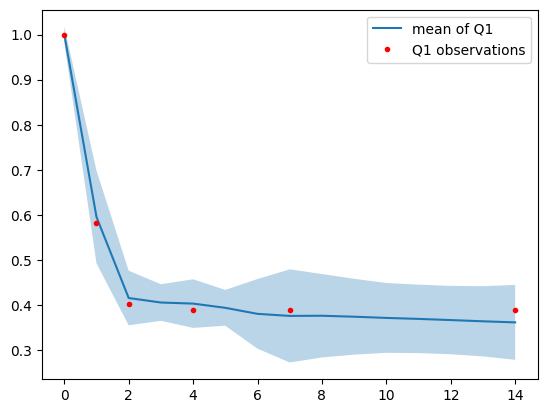

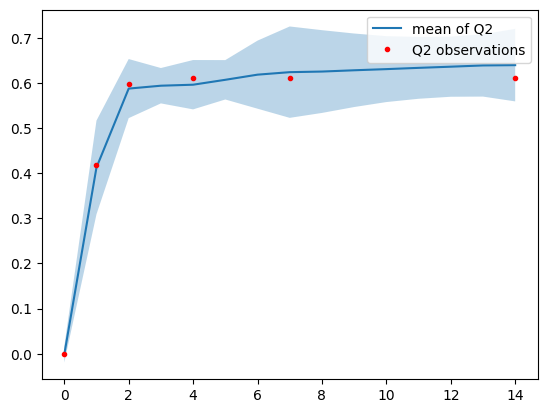

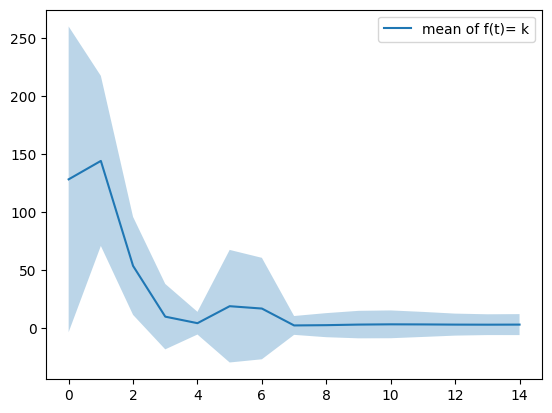

In [ ]:
plt.figure()
plt.plot(t_dense, overall_mu_Q1, label="mean of Q1")
plt.plot(t_data, Q1_measured, ".r", label="Q1 observations")
plt.fill_between(
    t_dense.reshape([-1]),
    (overall_mu_Q1 + 2 * overall_std_Q1).reshape([-1]),
    (overall_mu_Q1 - 2 * overall_std_Q1).reshape([-1]),
    alpha=0.3,
)
plt.legend()
plt.show()

plt.figure()
plt.plot(t_dense, overall_mu_Q2, label="mean of Q2")
plt.plot(t_data, Q2_measured, ".r", label="Q2 observations")
plt.fill_between(
    t_dense.reshape([-1]),
    (overall_mu_Q2 + 2 * overall_std_Q2).reshape([-1]),
    (overall_mu_Q2 - 2 * overall_std_Q2).reshape([-1]),
    alpha=0.3,
)
plt.legend()
plt.show()

plt.figure()
plt.plot(t_dense, overall_mu_f, label="mean of f(t)= k")
# plt.plot(t_data, Q1_measured, ".", label="Q1 observations")
plt.fill_between(
    t_dense.reshape([-1]),
    (overall_mu_f + 2 * overall_std_f).reshape([-1]),
    (overall_mu_f - 2 * overall_std_f).reshape([-1]),
    alpha=0.3,
)
plt.legend()
plt.show()

# plt.plot(t_test, Q2, label="reference of I")
# plt.plot(t_test, mu_Q2, label="mean of R")
# plt.plot(t_train, Q2_train * scale, ".", label="observations")
# plt.fill_between(
#     t_test.reshape([-1]),
#     (mu_Q2 + 2 * std_Q2).reshape([-1]),
#     (mu_Q2 - 2 * std_Q2).reshape([-1]),
#     alpha=0.3,
# )
# plt.plot(t_test, f_pred, label="reference of R")
# plt.plot(t_test, mu_f, label="mean of D (re-scaled)")
# # plt.plot(t_train, f_train * scale, ".", label="observations")
# plt.fill_between(
#     t_test.reshape([-1]),
#     (mu_f + 2 * std_f).reshape([-1]),
#     (mu_f - 2 * std_f).reshape([-1]),
#     alpha=0.3,
# )
# plt.plot(t_test, f, label="reference of D")
